In [32]:
import time
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchaudio

import s3prl
import scipy
import numpy as np
import matplotlib.pyplot as plt

from wav2avatar.streaming.hifigan.wav_ema_dataset import WavEMADataset
import wav2avatar.streaming.hifigan.layers as layers
from wav2avatar.streaming.hifigan.hifigan_discriminators import HiFiGANMultiScaleMultiPeriodDiscriminator
from wav2avatar.streaming.hifigan.hifigan_generator import HiFiGANGenerator
import wav2avatar.streaming.hifigan.collate as wav_ema_collate

import wav2avatar.streaming.hifigan.losses as hifigan_losses

from importlib import reload
import wav2avatar
reload(hifigan_losses)
reload(wav2avatar.streaming.hifigan.hifigan_generator)
from wav2avatar.streaming.hifigan.hifigan_generator import HiFiGANGenerator
from wav2avatar.streaming.hifigan.losses import GeneratorAdversarialLoss, DiscriminatorAdversarialLoss, FeatureMatchLoss

from wav2avatar.inversion.linear_inversion import EMADataset

In [33]:
device = 0
disc = HiFiGANMultiScaleMultiPeriodDiscriminator().to(device)
gen = HiFiGANGenerator(
    in_channels=512, 
    out_channels=12, 
    ar_input=600, 
    use_tanh=False,
    use_mlp_ar=True,
    resblock_kernel_sizes=(3, 7, 11, 15, 19),
    resblock_dilations=[(1, 3, 5), (1, 3, 5), (1, 3, 5), (1, 3, 5), (1, 3, 5)],
                       ).to(device)

disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=[0.5, 0.9], weight_decay=0.0)
disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(disc_optimizer, gamma=0.5, milestones=[40000, 80000, 120000, 160000])

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=[0.5, 0.9], weight_decay=0.0)
gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_optimizer, gamma=0.5, milestones=[40000, 80000, 120000, 160000])

disc_adv_loss = DiscriminatorAdversarialLoss()
gen_adv_loss = GeneratorAdversarialLoss()
feat_match_loss = FeatureMatchLoss()

/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [34]:
gen.load_state_dict(torch.load('ckpts/hfcar_l1_noup_5res_90_0.84.pth')["gen_state_dict"])

<All keys matched successfully>

In [4]:
torch.manual_seed(0)
dataset = WavEMADataset()
train_amt = int(len(dataset) * 0.9)
test_amt = len(dataset) - train_amt
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_amt, test_amt])
dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=wav_ema_collate.car_collate)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=100, 
    shuffle=True, 
    collate_fn=wav_ema_collate.car_collate)

Loading files from directories...


/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
len(test_dataset)

8833

In [6]:
def train_disc_step(batch):
    x = batch[0].to(device)
    y = batch[1].to(device)
    ar = batch[2].to(device)
    #print(f"Loaded batch with shapes x: {x.shape}, y: {y.shape}, ar: {ar.shape}")

    # (3) Get predictions
    with torch.no_grad():
        y_hat = gen(x, ar)
    p = disc(y)
    p_hat = disc(y_hat)

    #print(f"Generated shape: {y_hat.shape}, Discriminator prediction shape: {len(p)}, Discriminator prediction on generated shape: {len(p_hat)}")

    # (4) Calculate loss
    real_loss, fake_loss = disc_adv_loss(p_hat, p)
    disc_loss = real_loss + fake_loss
    #print(f"Discriminator loss: {disc_loss}")

    # (5) Backprop
    disc_optimizer.zero_grad()
    disc_loss.backward()
    disc_optimizer.step()
    disc_scheduler.step()

    return disc_loss

In [7]:
def train_gen_step(batch):
    x = batch[0].to(device)
    y = batch[1].to(device)
    ar = batch[2].to(device)

    y_hat = gen(x, ar)
    p_hat = disc(y_hat)
    p = disc(y)

    adv_loss = gen_adv_loss(p_hat)

    feat_loss = feat_match_loss(p_hat, p)
    #print(f"Generator loss: {adv_loss}")

    ema_loss = F.l1_loss(y_hat[:, :, :50], y)

    gen_loss = adv_loss + 2 * feat_loss + 45 * ema_loss

    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()
    gen_scheduler.step()

    return gen_loss

In [5]:
def unroll_collated(features):
    return torch.concatenate(list(features), dim=1)

In [6]:
test_feats = torch.zeros((40, 12, 50))
unroll_collated(test_feats).shape

torch.Size([12, 2000])

In [7]:
@torch.no_grad()
def eval_gen(batch):
    x = batch[0].to(device)
    y = batch[1].to(device)
    y_unrolled = unroll_collated(y)

    ar = torch.zeros((1, 12, 50)).to(device)
    pred = []
    for audio_feat in x:
        #print(audio_feat.shape, ar.shape)
        pred.append(gen(audio_feat.unsqueeze(0), ar)[:, :, :50])
        ar = pred[-1][:, :, :50]
    full_pred = torch.concatenate(pred, dim=2).squeeze(0)
    #print(full_pred.shape)
    full_pred = full_pred.transpose(1, 0).cpu().numpy()
    y_unrolled = y_unrolled.transpose(1, 0).cpu().numpy()
    #print(full_pred.shape, y_unrolled.shape)
    #print("First feature corr:", scipy.stats.pearsonr(full_pred[:, 0], y_unrolled[:, 0]))
    corrs = []
    for i in range(12):
        corrs.append(scipy.stats.pearsonr(full_pred[:, i], y_unrolled[:, i])[0])
    print("Correlations:", np.mean(corrs))
    return full_pred, y_unrolled

In [8]:
feature_model = getattr(s3prl.hub, "wavlm_large")()
feature_model = feature_model.model.feature_extractor.to(device)

In [9]:
@torch.no_grad()
def eval_audio(audio, true_ema):
    ar = torch.zeros((1, 12, 50)).to(device)

    audio_feats = feature_model(audio.to(device))
    print(audio_feats.shape)

    collated_audio = wav_ema_collate.collate_features(audio_feats.unsqueeze(0))
    print("collated_audio:", collated_audio.shape)

    pred = []
    for audio_feat in collated_audio:
        #print(audio_feat.shape, ar.shape)
        pred.append(gen(audio_feat.unsqueeze(0), ar)[:, :, :])
        ar = pred[-1][:, :, :]
    full_pred = torch.concatenate(pred, dim=2).squeeze(0)
    #print(full_pred.shape)
    full_pred = full_pred.transpose(1, 0).cpu().numpy()

    print(full_pred.shape, true_ema.shape)
    return full_pred

In [35]:
audio_file = "/data/all_data/VCTK/p225/wav_16/p225_003_mic1.wav"
ema_file = "/data/prabhune/VCTK/p225/mngu0_wlm_est/p225_003_mic1.npy"
audio, sr = torchaudio.load("../../inversion/wav/mngu0_s1_1165.wav")
#audio, sr = torchaudio.load(audio_file)
audio = torchaudio.functional.resample(
    audio, orig_freq=sr, new_freq=16000
)[0].unsqueeze(0)
print(audio.shape)
print(sr)
#audio = torch.concatenate([audio, audio], dim=1)
#print(audio.shape)
true_ema = np.load("../../inversion/ema/mngu0_s1_1165_gt.npy")
true_ema = EMADataset.downsample_by_mean(true_ema, int(200 / 50))
mngu0_to_hprc(true_ema)
#true_ema = np.load(ema_file)
print(true_ema.shape)
start = time.time()
pred_ema = eval_audio(audio, true_ema)
#pred_ema = pred_ema[len(pred_ema) // 2:]
end = time.time()
print(end - start)

torch.Size([1, 86022])
16000
(261, 12)
torch.Size([1, 512, 268])
collated_audio: torch.Size([5, 512, 50])
(250, 12) (261, 12)
0.031707048416137695


In [24]:
def mngu0_to_hprc(arr):
    arr_td = arr[:, 0:2]

    arr_tb = arr[:, 2:4]

    arr_tt = arr[:, 4:6]

    arr_li = arr[:, 6:8] # locked

    arr_ul = arr[:, 8:10] # locked

    arr_ll = arr[:, 10:12] # locked

    arr[:, 0] = arr_li[:, 0] * -1
    arr[:, 1] = arr_li[:, 1]
    arr[:, 2] = arr_ul[:, 0] * -1
    arr[:, 3] = arr_ul[:, 1]
    arr[:, 4] = arr_ll[:, 0] * -1
    arr[:, 5] = arr_ll[:, 1]
    arr[:, 6] = arr_tt[:, 0] * -1
    arr[:, 7] = arr_tt[:, 1]
    arr[:, 8] = arr_tb[:, 0] * -1
    arr[:, 9] = arr_tb[:, 1]
    arr[:, 10] = arr_td[:, 0] * -1
    arr[:, 11] = arr_td[:, 1]

In [7]:
collated_audio = wav_ema_collate.collate_features(audio.unsqueeze(0).unsqueeze(0))
print(collated_audio.shape)

torch.Size([5031, 1, 50])


In [16]:
121411 / 16000

7.5881875

In [105]:
np.save("ema/pataka_hfcar_conv.npy", pred_ema)

In [93]:
#pred, target = eval_gen(next(iter(dataloader)))
pred, target = eval_gen(batch)

NameError: name 'batch' is not defined

In [65]:
target.shape

(2200, 12)

Feature corr: PearsonRResult(statistic=0.8122869711265487, pvalue=5.334916374009893e-60)


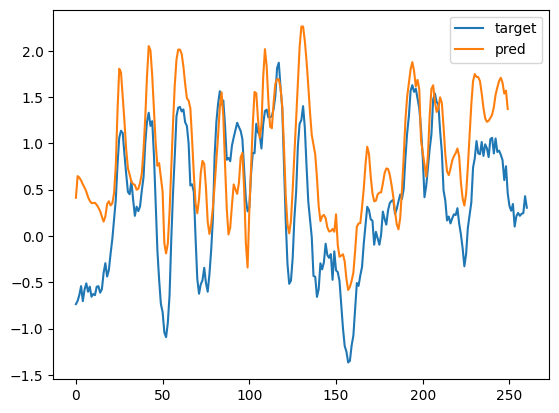

In [36]:
feat_num = 0
plt.plot(true_ema[:, feat_num], label="target")
plt.plot(pred_ema[:, feat_num], label="pred")
plt.legend()
print("Feature corr:", scipy.stats.pearsonr(pred_ema[:len(pred_ema), feat_num], true_ema[:len(pred_ema), feat_num]))

In [ ]:
step = 0
disc_start = 0
gen_start = 1

eval_step = 200

# (1) (2) Get batch
data_tqdm = tqdm(dataloader)
gen_loss = torch.tensor([999])
disc_loss = torch.tensor([999])

test_batch = next(iter(test_dataloader))

for batch in data_tqdm:
    data_tqdm.set_description(f"Training step {step}")

    #if step > 500:
    #    break

    if step >= gen_start:
        gen_loss = train_gen_step(batch)

    if step >= disc_start and step % 5 == 0:
        disc_loss = train_disc_step(batch)
    
    if step % eval_step == 0:
        pred_ema, true_ema = eval_gen(test_batch)
        feat_num = 0
        plt.plot(true_ema[:300, feat_num], label="target")
        plt.plot(pred_ema[:300, feat_num], label="pred")
        plt.legend()
        plt.show()

    data_tqdm.set_postfix(gen_loss=gen_loss.item(), disc_loss=disc_loss.item())
    step += 1

Correlations: 0.8545931528065331


(array([[ 0.33905143,  0.19300248, -0.12231358, ..., -0.50539756,
         -0.34806234,  0.19896682],
        [ 0.34663725, -0.0533323 , -0.10312922, ..., -0.9119205 ,
         -0.36918372, -0.05374521],
        [ 0.30498528, -0.2741149 , -0.04127889, ..., -0.916835  ,
         -0.3119843 , -0.28293976],
        ...,
        [-0.00260679, -0.91502064,  0.9950433 , ..., -0.99852353,
         -0.03752361, -0.90815663],
        [ 0.15240715, -0.8934425 ,  0.99751717, ..., -0.99929386,
         -0.1444557 , -0.8856277 ],
        [ 0.44184688, -0.5431973 ,  0.99646544, ..., -0.9992268 ,
         -0.4296255 , -0.5353927 ]], dtype=float32),
 array([[-0.4171819 ,  0.17515714,  0.01164838, ..., -0.7321942 ,
          0.4171819 ,  0.17515714],
        [ 0.2569627 , -0.09680475,  0.56220037, ..., -1.3572161 ,
         -0.2569627 , -0.09680475],
        [-0.24944264, -0.60957545,  0.16031568, ..., -1.4061717 ,
          0.24944264, -0.60957545],
        ...,
        [-0.480926  , -1.2900146 ,  1.1

In [259]:
torch.save({
    'gen_state_dict': gen.state_dict(),
    'disc_state_dict': disc.state_dict(),
    'gen_optimizer_state_dict': gen_optimizer.state_dict(),
    'disc_optimizer_state_dict': disc_optimizer.state_dict(),
    'gen_scheduler_state_dict': gen_scheduler.state_dict(),
    'disc_scheduler_state_dict': disc_scheduler.state_dict()
}, "ckpts/hfcar_90_0.738.pth")

In [1]:
loaded_generator = HiFiGANGenerator(in_channels=512, out_channels=12, ar_input=600).to(device)
loaded_generator.load_state_dict(torch.load("ckpts/hfcar_tanh_100_0.855.pth")['gen_state_dict'])

NameError: name 'HiFiGANGenerator' is not defined

In [153]:
old_generator = gen
gen = loaded_generator

In [10]:
test_batch = next(iter(test_dataloader))

In [11]:
pred_ema, true_ema = eval_gen(test_batch)

Correlations: 0.8394673303480653


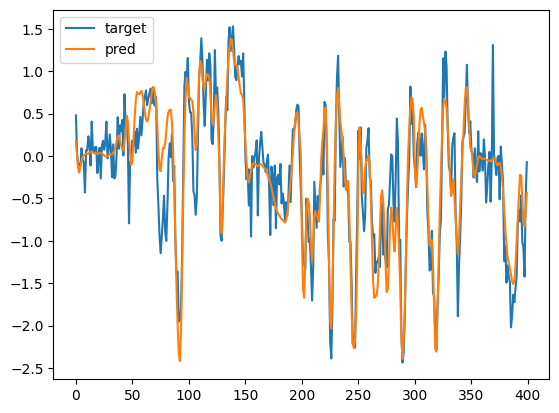

PearsonRResult(statistic=0.8486266582198785, pvalue=4.030989083519492e-112)


In [12]:
feat_num = 1
plt.plot(true_ema[:400, feat_num], label="target")
plt.plot(pred_ema[:400, feat_num], label="pred")
plt.legend()
plt.show()

print(scipy.stats.pearsonr(pred_ema[:400, 0], true_ema[:400, 0]))

In [37]:
colors = ["firebrick", 
          "gold", 
          "skyblue", 
          "lightgreen", 
          "orchid", 
          "cornflowerblue"]
parts = ["li", "ul", "ll", "tt", "tb", "td"]
def get_flattened_range(arr, start, end):
    dim = arr[:, start:end]
    dim = list(dim.reshape(len(dim),))
    return dim

def get_corrs_npy(ground_truth, predicted, lower_hz=False, get_traces=False):

    if lower_hz:
        ground_truth = lower_hz(ground_truth)
    min_length = min(len(ground_truth), len(predicted))
    ground_truth = ground_truth[:min_length]
    predicted = predicted[:min_length]

    gt_parts = []
    p_parts = []

    for i in range(0, 12):
        gt_parts.append(get_flattened_range(ground_truth, i, i + 1))
        p_parts.append(get_flattened_range(predicted, i, i + 1))
    

    corrs = []
    corr_dict = {}

    for part in parts:
        corr_dict[part] = []

    for i in range(12):
        corr = scipy.stats.pearsonr(gt_parts[i], p_parts[i])
        corrs.append(corr)
        corr_dict[parts[i // 2]].append(corr.statistic)

    if get_traces:
        return corr_dict, gt_parts, p_parts
    else:
        return corr_dict

def graph_all_part_comparisons(ground_truth, predicted, title=None):
    fig, ax = plt.subplots(12, 1, figsize=(12, 14), sharex=True)
    fig.subplots_adjust(hspace=0)
    #pred_ema = NEMAData(pred_path + filename)
    #gt_ema = NEMAData(gt_path + filename)
    corrs, gt_ema, pred_ema = get_corrs_npy(ground_truth, predicted, get_traces=True)

    dims = ["x", "y"]
    offset = 50
    offset_data = lambda data, i: [x + offset * i for x in data]

    fig.text(0.5, 0.06, 'Frame', ha='center')
    fig.text(0.04, 0.5, 'Articulator', va='center', rotation='vertical')
    if not title:
        fig.suptitle(f"Time Scale Comparison")
    else:
        fig.suptitle(title)
    plt.subplots_adjust(top=0.95)

    offset_counter = 0
    for i in range(len(parts)):
        part = parts[i]
        for dim in range(2):
            pred_data = pred_ema[offset_counter]
            #pred_data = offset_data(pred_data, offset_counter)
            pred_time_scale = list(range(len(pred_data)))

            gt_data = gt_ema[offset_counter]
            #gt_data = offset_data(gt_data, offset_counter)
            gt_time_scale = list(range(len(gt_data)))

            ax[offset_counter].plot(pred_time_scale, pred_data, '-', label="pred", color=colors[i])
            ax[offset_counter].plot(gt_time_scale, gt_data, '-', label="gt", color="black")

            ax[offset_counter].spines['top'].set_visible(False)
            ax[offset_counter].spines['right'].set_visible(False)
            ax[offset_counter].spines['bottom'].set_visible(False)

            ax[offset_counter].yaxis.set_tick_params(labelleft=False)
            ax[offset_counter].set_yticks([])

            ax[offset_counter].set_ylabel(f"{part} {dims[dim]}")

            ax2 = ax[offset_counter].secondary_yaxis('right')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
            ax2.set_ylabel(f"{round(corrs[part][dim], 2)}", rotation="horizontal")
            ax2.spines['right'].set_visible(False)

            offset_counter += 1
    ax[11].spines['bottom'].set_visible(True)
    #fig.savefig("../../../ICASSP/figures/transformer_correlations_2_sec.pdf")

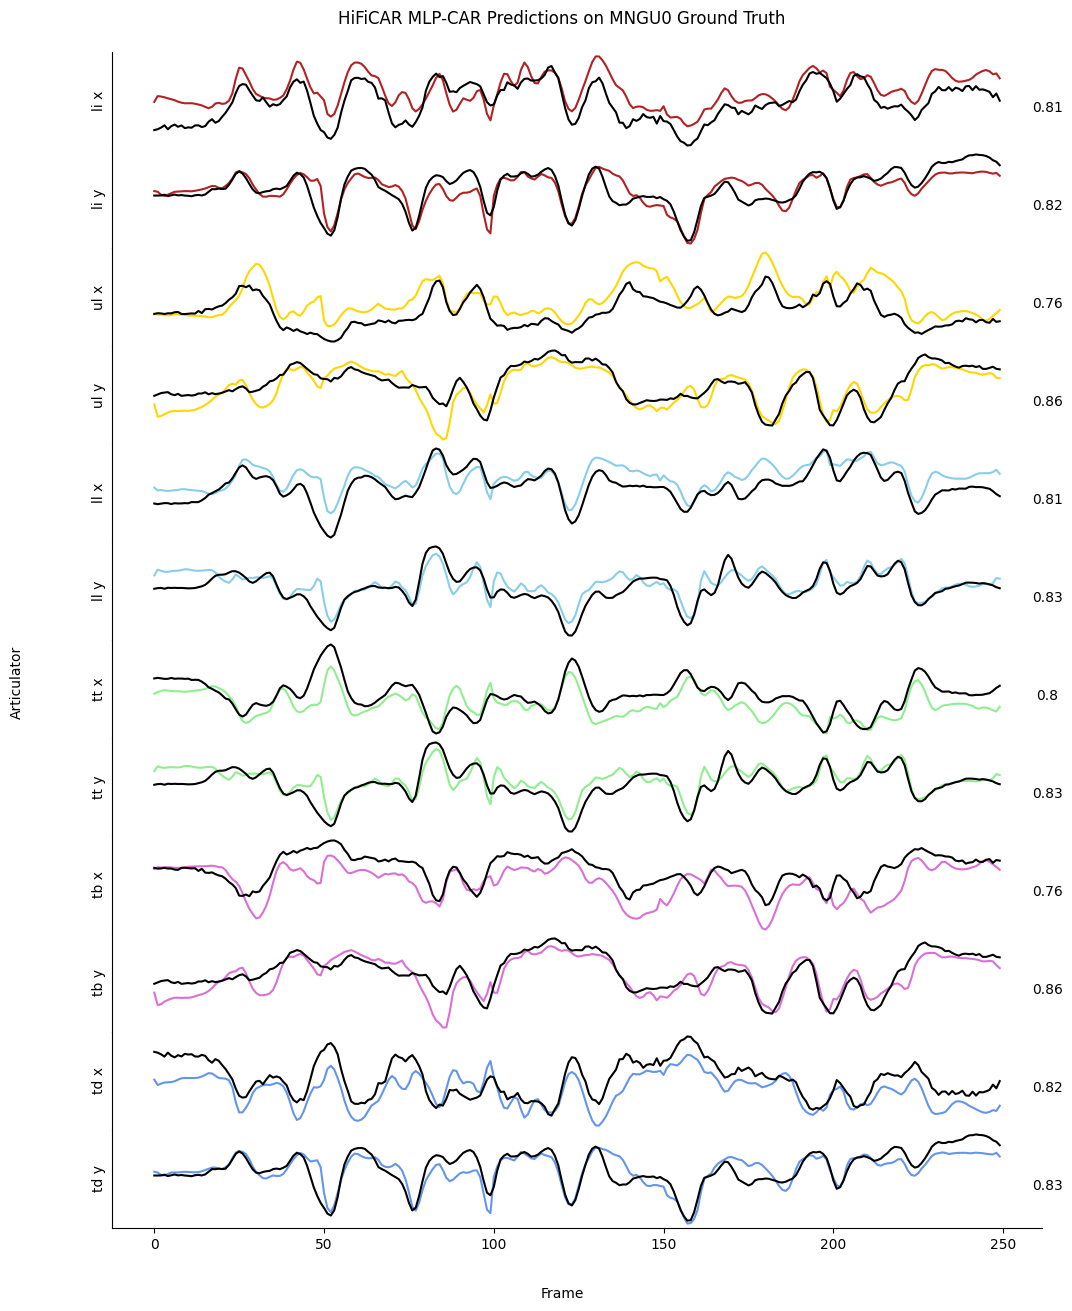

In [39]:
graph_all_part_comparisons(true_ema[:400], pred_ema[:400], title="HiFiCAR MLP-CAR Predictions on MNGU0 Ground Truth")

In [139]:
ar_conv = torch.nn.Sequential(
    torch.nn.Conv1d(600, 128, kernel_size=3, padding=1),
    #torch.nn.Conv1d(128, 128, kernel_size=3, padding=1),
    #torch.nn.Linear(50, 128)
)

In [147]:
ar_model = layers.PastFCEncoder(input_len=600, hidden_dim=256, output_dim=128)

x = torch.randn(2, 12, 50)
print(x.shape)
x = x.reshape(x.shape[0], -1)
print(x.shape)
print(ar_conv(x).shape)
print(ar_model(x).shape)

torch.Size([2, 12, 50])
torch.Size([2, 600])


RuntimeError: Given groups=1, weight of size [128, 600, 3], expected input[1, 2, 600] to have 600 channels, but got 2 channels instead